In [8]:
import sys, os, glob
user = os.path.expanduser('~')

sys.path.insert(0, f'{user}/Dropbox/Projects/social_navigation_task/social_navigation_task')
sys.path.insert(0, f'{user}/Dropbox/Projects/toolbox/toolbox')
sys.path.insert(0, '..')

import info as snt_info
import preprocess as snt_preprc
from circ_stats import *

import re
import scipy

# from sklearn.preprocessing import OrdinalEncoder

base_dir = '/Volumes/synapse/projects/SocialSpace/Projects/SNT-fmri_CUD'
data_dir = f'{base_dir}/Data/Summary'
df = pd.read_excel(glob.glob(f'{data_dir}/All-data*')[0])
df = df[df['memory_mean'] > .25]

incl_df = pd.read_excel(f'{base_dir}/included_sub_ids.xlsx')
df = df[df['sub_id'].isin(incl_df['sub_id'].values)].reset_index(drop=True)

print(f'n={len(df)}')
sub_list = df['sub_id']
print(df['dx'].value_counts())

n=63
HC    33
CD    30
Name: dx, dtype: int64


In [5]:
demo_controls = ['sex', 'age_years', 'race___white'] # , 'mentalizing_initial_screening_edu_level']
task_preds = ['affil_tendency_mean', 'power_tendency_mean',
              'ego2d_angles_end_mean', 'ego_dists_end_mean',
              'allo2d_angles_end_mean', 'allo_dists_end_mean',
              'allo_consistency_mean', 'allo2d_area', 'allo3d_volume']

# Group differences

## Demographics

In [43]:
# educaiton
print(np.unique(df['mentalizing_initial_screening_edu_level']))
recode = {'some_hs':1,'hs_ged':2,'some_college':3,'associates':4,'bachelors':5,'masters':6}
df['edu_level'] = np.nan
for level, l in recode.items():
    level_mask = df['mentalizing_initial_screening_edu_level'] == level
    df['edu_level'][level_mask] = l
    
# drug use variables
df['alc_rgu_dur_years'][df['alc_rgu_dur_years'] == 'no regular use'] = 0


# CLEAN UP 
coc_dur = []
for y in df['coc_cur_duration_years'].values:
    if type(y) == str:
        if 'months' in y:
            y = strip_nonnumeric(y)
            y = int(y)/12
        elif 'years' in y:
            y = int(strip_nonnumeric(y))
    coc_dur.append(y)
df['coc_cur_duration_years_clean'] = np.array(coc_dur)

df = df.astype({"alc_rgu_dur_years": float},
               {'coc_cur_duration_years_clean': float})

['associates' 'bachelors' 'hs_ged' 'masters' 'some_college' 'some_hs']


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [5]:
[c for c in df.columns if 'nic' in c]

['ethnicity',
 'nicotine_hx',
 'nicotine_type___cigarette',
 'nicotine_type___chewing_tobacco',
 'nicotine_type___vape',
 'nicotine_type___patch',
 'nicotine_age_1st_use',
 'nicotine_age_regular_use',
 'nicotine_rgu_dur_years',
 'asi_chronic_medproblems',
 'mini_manic_epi',
 'mini_manic_epi_specifier___current',
 'mini_manic_epi_specifier___past',
 'mini_hypomanic_epi',
 'mini_hypomanic_epi_specifier___current',
 'mini_hypomanic_epi_specifier___past',
 'mini_hypomanic_epi_specifier___not_explored',
 'mini_panic_dis',
 'mini_panic_dis_spec___current',
 'mini_panic_dis_spec___lifetime',
 'mini_secondary_dx___panic_do_current',
 'mini_secondary_dx___panic_do_lifetime',
 'mentalizing_dailyinterview_othr_nicotine',
 'mentalizing_dailyinterview_othr_nicotine_specify',
 'mentalizing_dailyinterview_time_othr_nicotine']

### Continuous variables

In [44]:
[c for c in df.columns if 'coc' in c]

['mentalizing_initial_screening_used_cocaine',
 'mentalizing_initial_screening_drug_quit___coc',
 'mentalizing_initial_screening_screen_coc_abs',
 'mentalizing_initial_screening_cocaine_quit',
 'mentalizing_initial_screening_current_tx_cocaine',
 'screen_utox___coc',
 'coc_hx',
 'coc_last_use',
 'coc_days_last_use',
 'coc_lst_amount',
 'coc_lst_money',
 'coc_progression',
 'coc_age_1st_use',
 'coc_age_reg_use',
 'coc_dur_years',
 'coc_phu',
 'coc_phu_patt',
 'coc_phu_number',
 'coc_phu_amount',
 'coc_phu_money',
 'coc_phu_duration',
 'coc_cur_patt',
 'coc_cur_number',
 'coc_cur_amount',
 'coc_cur_money',
 'coc_cur_duration_years',
 'coc_pastyr_patt',
 'coc_pastyr_number',
 'coc_pastyr_amount',
 'coc_pastyr_money',
 'coc_number_quit',
 'coc_longest_abstinence',
 'coc_inpt_tx',
 'coc_outpt_tx',
 'coc_detx_tx',
 'coc_na_meetings',
 'asi_coc_pastmonth',
 'asi_coc_lifetime_years',
 'asi_coc_roa1',
 'asi_coc_roa2',
 'cssa_4_coccrav',
 'cssa_5_coccravfreq',
 'stcq_screen_wantcoc_taste',
 'stc

In [45]:
cd = df[df['dx'] == 'CD']
hc = df[df['dx'] == 'HC']

## t-tests 
# demo: age, education
# drug use: nicotine, alcohol, canabis, cocaine
# 'nicotine_rgu_dur_years'
# ['ctq_total_score_2', 'age_years', 'edu_level', 'wrat_grade_equiv', 'stcq_mri_no_desire_coc', 'coc_days_last_use', 'coc_cur_duration_years', 'alc_rgu_dur_years', 'thc_duration_years']


# 'wrat_blue_score_total', 'wrat_tan_total_score']
for measure in ['coc_dur_years', 'wasi_total']:

    display(df[["dx", measure]].groupby("dx").describe())

    cd_ = cd[np.isfinite(cd[measure])]
    hc_ = hc[np.isfinite(hc[measure])]
    b,p = scipy.stats.shapiro(cd[measure])
    
    if p < 0.05: # not normal --> mannwhitney u test
        # also better for ordinal data: eg, education level
        t,p = scipy.stats.mannwhitneyu(cd_[measure],
                                       hc_[measure])
        print(f'{measure} mannwhitneyu p={np.round(p,5)}')
    else: # normal --> ttest
        b,p = scipy.stats.bartlett(cd_[measure], hc_[measure])
        if p < 0.05: # assume unequal variances
            stat,p = scipy.stats.ttest_ind(cd_[measure], hc_[measure], equal_var=False)
            print(f'{measure} unequal variances t={np.round(stat,5)} p={np.round(p,5)}')
        else:
            stat,p = scipy.stats.ttest_ind(cd_[measure], hc_[measure], equal_var=True)
            print(f'{measure} equal variances t={np.round(stat,5)} p={np.round(p,5)}')
            
#     # sns.histplot(data_mj_[measure], color='red')
#     # sns.histplot(data_hc_[measure])
#     # plt.show()

coc_dur_years                                                
           count   mean        std  min   25%   50%    75%   max
dx                                                              
CD          30.0  21.95  12.026085  0.0  12.0  25.5  31.75  42.0
HC          32.0   0.00   0.000000  0.0   0.0   0.0   0.00   0.0

coc_dur_years unequal variances t=9.99703 p=0.0


//anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2467: RuntimeWarning: divide by zero encountered in log
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)


wasi_total                                                   
        count       mean       std   min   25%   50%   75%   max
dx                                                              
CD       30.0  22.866667  6.032860   7.0  20.0  24.5  27.0  33.0
HC       33.0  24.969697  3.940851  18.0  22.0  25.0  28.0  32.0

wasi_total unequal variances t=-1.62069 p=0.11148


### Categorical variables

In [10]:
# chi-square tests
cat_vars = {"race___aa": [1, 0], "sex": ['male', 'female']}
for cat_var, cats in cat_vars.items():
    
    cd_1   = np.sum(cd[cat_var] == cats[0])
    cd_2   = np.sum(cd[cat_var] == cats[1])
    hc_1   = np.sum(hc[cat_var] == cats[0])
    hc_2   = np.sum(hc[cat_var] == cats[1])
    
    stat, p, dof, expected = scipy.stats.chi2_contingency([[cd_1, cd_2], [hc_1, hc_2]])
    print(f'{cat_var} chi-squared pvalue={np.round(p, 4)}')
    print([[cd_1, cd_2], [hc_1, hc_2]])

race___aa chi-squared pvalue=0.215
[[21, 9], [17, 16]]
sex chi-squared pvalue=0.0231
[[23, 7], [15, 18]]


## Memory: not different between groups

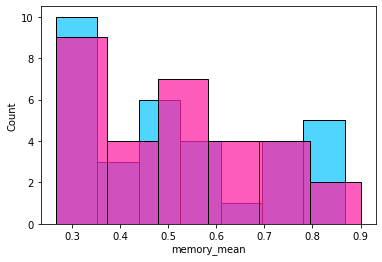

Ttest_indResult(statistic=0.11477543486730181, pvalue=0.9090000893311112)


In [104]:
sns.histplot(df[df['dx'] == 'HC']['memory_mean'], color=group_colors[0])
sns.histplot(df[df['dx'] == 'CD']['memory_mean'], color=group_colors[1])
plt.show()

print(scipy.stats.ttest_ind(df[df['dx'] == 'HC']['memory_mean'], df[df['dx'] == 'CD']['memory_mean']))

## Affil x Power coordinates

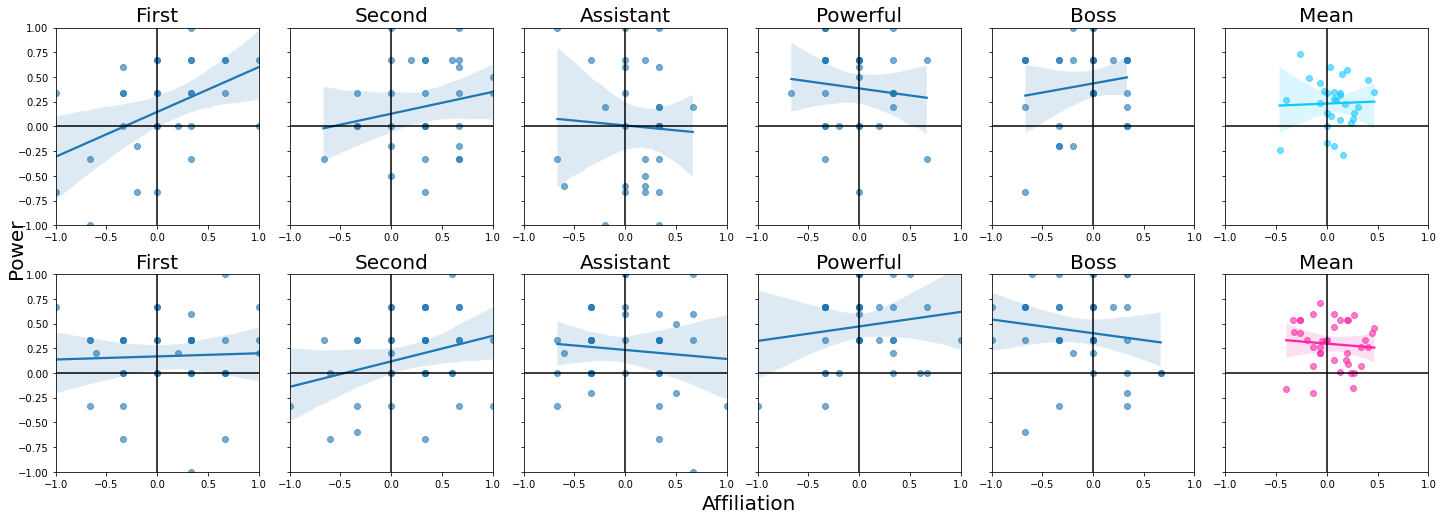

In [5]:
fig, axs = plt.subplots(2, 6, figsize=(20, 7), sharey=True)
fig.subplots_adjust(top=0.95)
fig.text(0.515, -0.02, 'Affiliation', ha='center', fontsize=20)
fig.text(0, 0.5, 'Power', va='center', rotation='vertical', fontsize=20)

for g, group in enumerate(np.unique(df['dx'])):
    color = group_colors[g]
    df_ = df[df['dx'] == group]
    for c in range(0,6):
        if c == 5:
            sns.regplot(x='affil_tendency_mean',y='power_tendency_mean', data=df_, 
                        scatter_kws={'alpha':0.6}, color=color,
                        ax=axs[g,c])
            axs[g,5].set_title('Mean', fontsize=20)
        else: 
            sns.regplot(x='affil_tendency_' + character_roles[c], 
                        y='power_tendency_' + character_roles[c], 
                        data=df_, 
                        scatter_kws={'alpha':0.6},
                        ax=axs[g,c])
            axs[g,c].set_title(character_roles[c].capitalize(), fontsize=20)
        axs[g,c].set_xlim(-1,1)
        axs[g,c].set_ylim(-1,1)
        axs[g,c].axhline(y=0, color='black')
        axs[g,c].axvline(x=0, color='black')
        axs[g,c].set_xlabel('')
        axs[g,c].set_ylabel('')
        
plt.tight_layout()
plt.show()
# jp.savefig(fig_dir + "/affil_power_correlation.png", dpi=150)

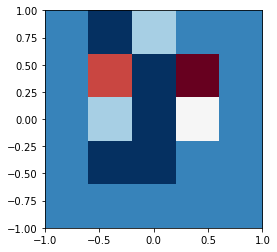

In [3]:
cd = df[df['dx'] == 'CD']
hc = df[df['dx'] == 'HC']
task_binedges = np.array([-1,-.6,-.2,.2,.6,1]) 
cd_h, _, _ = np.histogram2d(cd['affil_tendency_mean'], cd['power_tendency_mean'], bins=[task_binedges, task_binedges])
hc_h, _, _ = np.histogram2d(hc['affil_tendency_mean'], hc['power_tendency_mean'], bins=[task_binedges, task_binedges])
diff = cd_h.T - hc_h.T
plt.imshow(diff, interpolation=None, origin='lower',
            extent=[task_binedges[0], task_binedges[-1], task_binedges[0], task_binedges[-1]], cmap='RdBu')
plt.show()

### T-tests

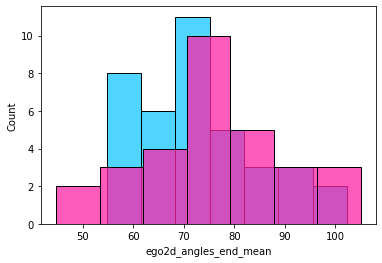

In [6]:
sns.histplot(df[df['dx'] == 'HC']['ego2d_angles_end_mean'], color=group_colors[0])
sns.histplot(df[df['dx'] == 'CD']['ego2d_angles_end_mean'], color=group_colors[1])
plt.show()

/Users/matthew/opt/anaconda3/lib/python3.9/site-packages/pycircstat/tests.py:416: UserWarning: Test not applicable. Average resultant vector length < 0.45.
  warnings.warn(


ego2d_angles_end_mean p=0.00272


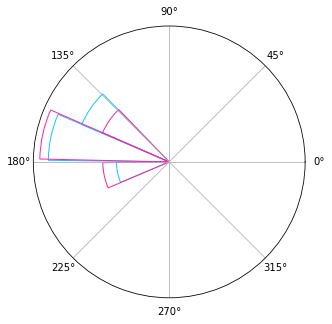

In [8]:
# have to correct the allo angles...
for var in task_preds:
    
    hc = df[df['dx'] == 'HC'][var]
    cd = df[df['dx'] == 'CD'][var]  
    
    if 'angles' in var:
        p,T = circ_wwtest(hc, cd)
        # polar histogram
        
        if p < 0.05:
            if 'ego2d' in var:
                # for visualization
                hc = hc + 90
                cd = cd + 90

            print(var + ' p=' + str(np.round(p,5)))
            fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(projection="polar"))
            n,bins,patches = circular_hist(ax, x=np.deg2rad(hc).values, color=group_colors[0]) # blue
            n,bins,patches = circular_hist(ax, x=np.deg2rad(cd).values, color=group_colors[1])  
            
    else:
        t,p = scipy.stats.ttest_ind(hc, cd)
        if p < 0.05:
            print(var + ' p=' + str(np.round(p,5)))
            sns.histplot(hc, color=group_colors[0]) # blue
            sns.histplot(cd, color=group_colors[1]) # pink
            plt.show()

In [14]:
for pred in task_preds:
    if 'angles' not in pred:
        long = pd.melt(df, id_vars=['sub_id', 'dx', 'sex', 'race___white', 'ctq_total_score_2'], 
                       value_vars=[pred])
        model = ols("value ~ C(sex, Sum) + C(race___white, Sum) + C(dx, Sum)", data=long).fit()
        aov_table = sm.stats.anova_lm(model, typ=3)
        p = aov_table.loc['C(dx, Sum)', 'PR(>F)']
        if p < 0.05: 
            print(pred)
            display(aov_table)

# Dots

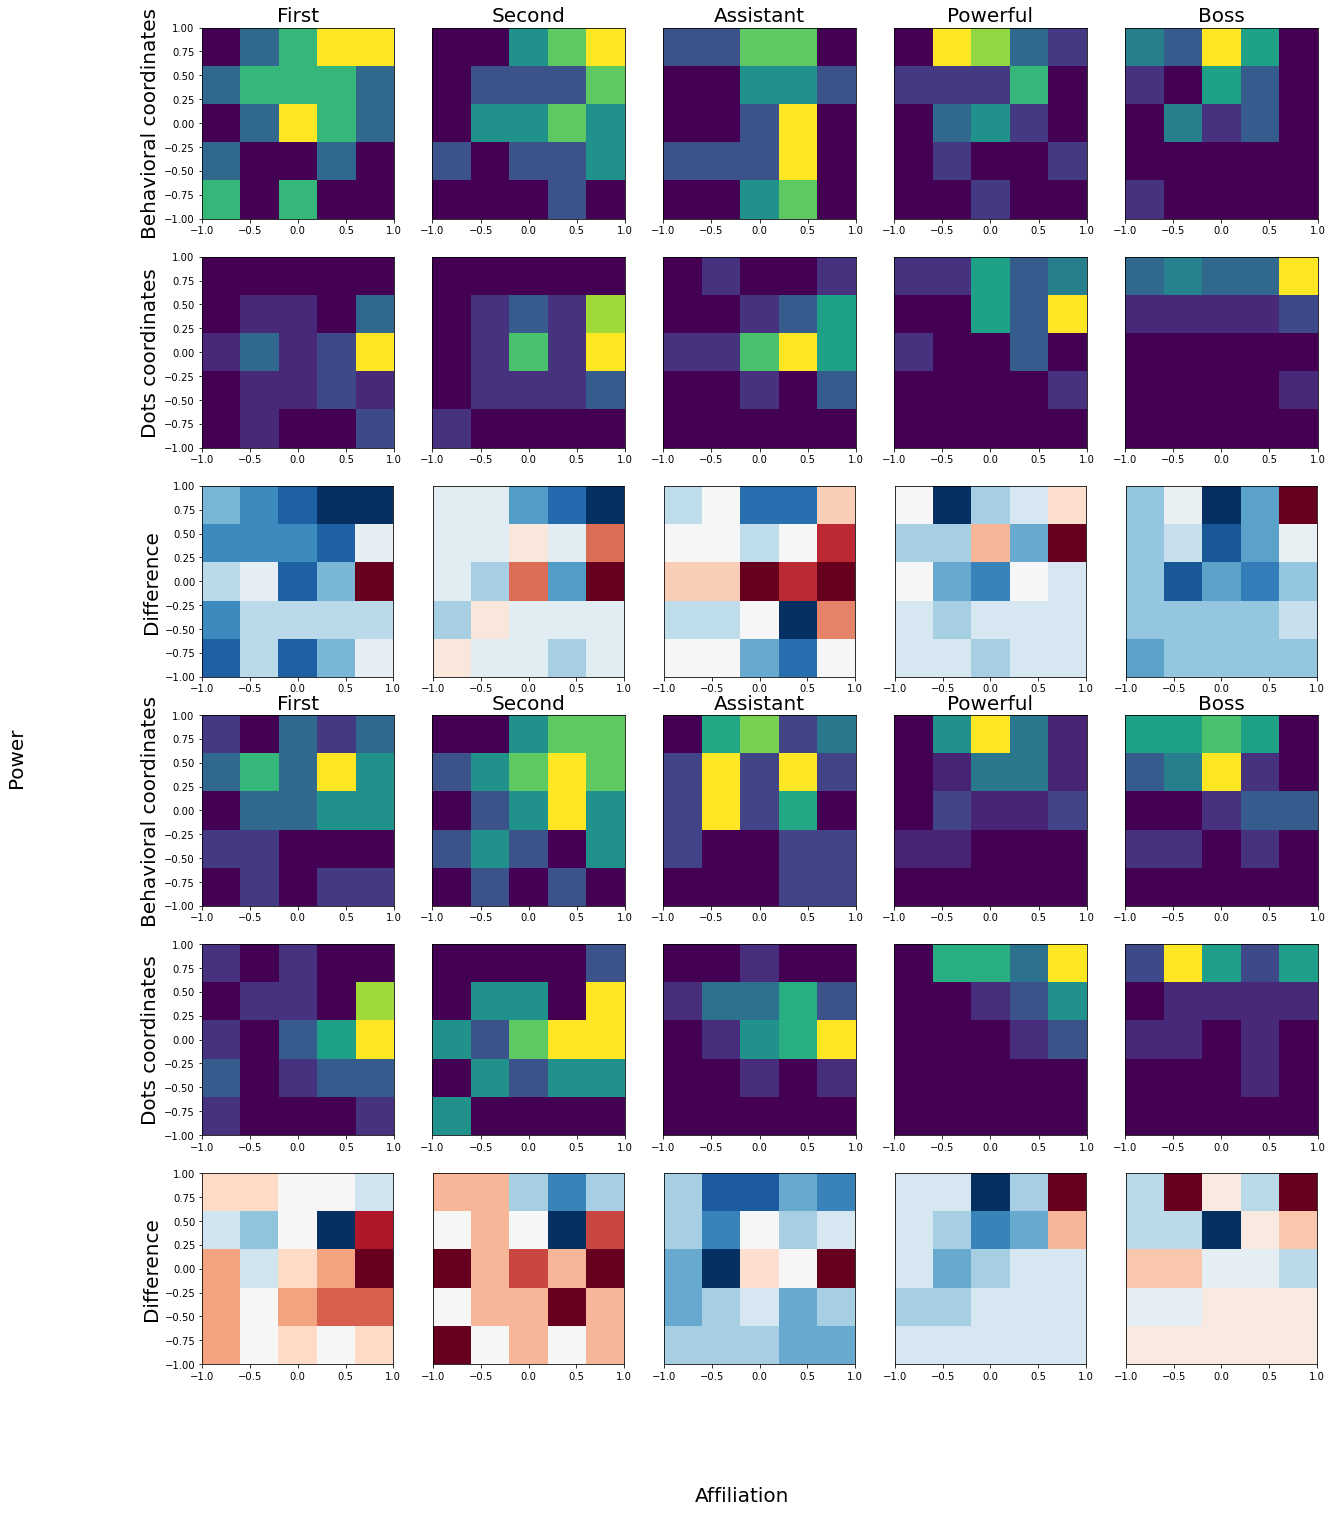

In [15]:
nrows = 3 * len(np.unique(df['dx']))
fig, axs = plt.subplots(nrows, 5, figsize=(20, 3.75*nrows))
fig.subplots_adjust(top=0.95)
fig.text(0.5, 0.04, 'Affiliation', ha='center', fontsize=20)
fig.text(-0.01, 0.5, 'Power', va='center', rotation='vertical', fontsize=20)

dots_binedges = np.array([0,200,400,600,800,1000])
rank_binedges = np.array([0,1,2,3,4,5])
task_binedges = np.array([-1,-.6,-.2,.2,.6,1]) 

character_roles_ = character_roles # + ['mean']
# character_colors_ = character_colors # + ['grey']

for g, group in enumerate(np.unique(df['dx'])):
    df_ = df[df['dx'] == group]
    
    for c, char in enumerate(character_roles_):

        axs[0+(3*g),c].set_title(character_roles_[c].capitalize(), fontsize=20)

        # behav place
        task_affil = df_['affil_tendency_' + char]
        task_power = df_['power_tendency_' + char]
        axs[0+(3*g),c].hist2d(task_affil, task_power, bins=[task_binedges, task_binedges]) # color=character_colors_[c])
        axs[0+(3*g),c].set_ylabel('Behavioral coordinates', fontsize=20)
        axs[0+(3*g),c].axis([-1, 1, -1, 1])

        # dots place 
        dots_power = df_['dots_power_' + char] 
        dots_affil = df_['dots_affil_' + char]
        axs[1+(3*g),c].hist2d(dots_affil, dots_power, bins=[task_binedges, task_binedges]) #color=character_colors_[c])
        axs[1+(3*g),c].set_ylabel('Dots coordinates', fontsize=20)
        axs[1+(3*g),c].axis([-1, 1, -1, 1])

        # behav - dots
        H1, _, _ = np.histogram2d(task_affil, task_power, bins=[task_binedges,task_binedges])
        H2, _, _ = np.histogram2d(dots_affil, dots_power, bins=[task_binedges,task_binedges])
        H12 = H1.T - H2.T
        axs[2+(3*g),c].imshow(H12, interpolation=None, origin='lower',
                        extent=[task_binedges[0], task_binedges[-1], task_binedges[0], task_binedges[-1]], cmap='RdBu')
        axs[2+(3*g),c].set_ylabel('Difference', fontsize=20)

        if c > 0: [axs[r,c].axes.get_yaxis().set_visible(False) for r in np.arange(0,nrows)] 

In [16]:
dots_cols = []
beh_cols  = []
for char in character_roles:
    dots_cols.append('dots_affil_' + char)
    dots_cols.append('dots_power_' + char)
    beh_cols.append('affil_tendency_' + char)
    beh_cols.append('power_tendency_' + char)

# add egocentric distance
for char in character_roles:
    
    char_mask = np.sum(np.isfinite(df[[c for c in dots_cols if char in c]]), 1) == 2
    xy = df[[c for c in dots_cols if char in c]][char_mask].values
    
    # from the theoretical pov
    xy_ego = xy - np.array([1, 0])
    df['dots_ego_dists_' + char] = np.nan
    df['dots_ego_dists_' + char][char_mask] = [l2_norm(v) for v in xy_ego]

    # from the empirical avoidance pov
    best_ref = np.array((6, -4)) / 6
    xy_best = xy - best_ref
    df['dots_best_dists_' + char] = np.nan
    df['dots_best_dists_' + char][char_mask] = [l2_norm(v) for v in xy_best]
    
for char in character_roles:
    dots_cols.append('dots_ego_dists_' + char)
    dots_cols.append('dots_best_dists_' + char)
    
df['dots_affil_mean'] = np.mean(df[[c for c in dots_cols if 'affil' in c]], 1)
df['dots_power_mean'] = np.mean(df[[c for c in dots_cols if 'power' in c]], 1)
df['dots_ego_dists_mean'] = np.mean(df[[c for c in dots_cols if 'ego_dists' in c]], 1)
df['dots_best_dists_mean'] = np.mean(df[[c for c in dots_cols if 'best_dists' in c]], 1)


/var/folders/jq/pk75wqp554g5dhplx1d3m91h0000gw/T/ipykernel_39140/3083897565.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dots_ego_dists_' + char][char_mask] = [l2_norm(v) for v in xy_ego]
/var/folders/jq/pk75wqp554g5dhplx1d3m91h0000gw/T/ipykernel_39140/3083897565.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dots_best_dists_' + char][char_mask] = [l2_norm(v) for v in xy_best]


In [13]:
task_preds_ = ['affil_tendency_mean', 'power_tendency_mean',
               'ego2d_angles_end_mean', 'ego_dists_end_mean',
               'allo_consistency_mean', 'allo2d_area', 'allo3d_volume']

cd = df[df['dx'] == 'CD']
coc_df = pd.DataFrame()
for coc in [c for c in df.columns if 'coc' in c]:
    try: 
        mask = cd[coc] > 0
        for pred in task_preds_:
            
#             r,p = scipy.stats.pearsonr(cd[coc][mask], cd[pred][mask])
            
            formula = pred + " ~  + " + coc + " + memory_mean + wrat_standard_score + asi_coc_lifetime_years + " + (' + ').join(demo_controls)
            model = ols(formula=formula, data=cd[mask])
            results = model.fit()
            ix = np.where(pd.DataFrame(results.pvalues).index == coc)[0][0]
            p = results.pvalues[ix]
            t = results.tvalues[ix]
            
            if p < 0.05: 
                coc_df.loc[len(coc_df), ['behav', 'coc', 'p', 't']] = [pred, coc, p, t]
#                 sns.regplot(x=coc, y=pred, data=df[mask], color=pal[1])
#                 plt.show()
    except:
        continue
        
try: 
    coc_df.sort_values(by='p')
except:
    print('no significant relationships...')

no significant relationships...


In [15]:
formula = "ego_dists_end_mean ~  + asi_coc_lifetime_years + memory_mean + wrat_standard_score + ctq_total_score_2"
model = ols(formula=formula, data=cd)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     ego_dists_end_mean   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                 -0.080
Method:                 Least Squares   F-statistic:                    0.4621
Date:                Mon, 12 Sep 2022   Prob (F-statistic):              0.763
Time:                        10:11:47   Log-Likelihood:                -47.017
No. Observations:                  30   AIC:                             104.0
Df Residuals:                      25   BIC:                             111.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4.1392      2.772      1.493      0.148      -1.570       9.848
asi_coc_lifetime_years    -0.0116      0.020     -0.565      0.577      -0.054       0.031
memory_mean                0.7759      1.478      0.525      0.604      -2.268       3.820
wrat_standard_score        0.0195      0.028      0.692      0.495      -0.039       0.077
ctq_total_score_2          0.0029      0.013      0.235      0.816      -0.023       0.029
==============================================================================
Omnibus:                        4.364   Durbin-Watson:                   2.274
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                3.141
Skew:                           0.781   Prob(JB):                        0.208
Kurtosis:                       3.269   Cond. No.                     1.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Behavior-Dots difference

In [17]:
from scipy.spatial import distance
ego_pos = [1, 0] # egocentric position
dist_change = []

mask = (np.isfinite(df['dots_affil_first'])) & (np.isfinite(df['power_tendency_first']))
for s, sub in df[mask].iterrows():
    sub_dists = []
    for c, char in enumerate(character_roles):
        task_pos = [sub['affil_tendency_' + char], sub['power_tendency_' + char]]
        dots_pos = [sub['dots_affil_' + char], sub['dots_power_' + char]]
        dots_dist = distance.euclidean(dots_pos, ego_pos)
        task_dist = distance.euclidean(task_pos, ego_pos) 
        dots_task_dist = distance.euclidean(dots_pos, task_pos)
        sub_dists.append(dots_task_dist)
    dist_change.append(sub_dists)
    
dist_df = pd.DataFrame(dist_change, columns=['distance_change.' + char for char in character_roles])
dist_df['distance_change.mean'] = np.mean(dist_df[['distance_change.' + char for char in character_roles]], axis=1)
dist_df = pd.concat([df[mask].reset_index(drop=True), dist_df], axis=1)

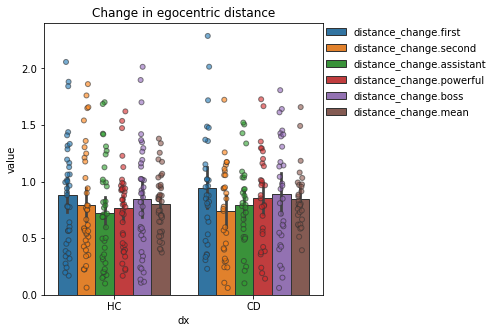

In [18]:
melted = pd.melt(dist_df, id_vars=['sub_id', 'dx'], value_vars=['distance_change.' + char for char in character_roles + ['mean']])

fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(x='dx', y='value', hue='variable', data=melted, edgecolor='.2')
sns.stripplot(x='dx', y='value', hue='variable', data=melted, 
             dodge=True, edgecolor=".2", alpha=.6, linewidth=1)
ax.set_title('Change in egocentric distance')
# ax.set_xticklabels(labels=['RES', 'PTSD', 'HC'], rotation=75)
handles, labels = plt.gca().get_legend_handles_labels()
l = plt.legend(title='', loc='upper right', handles=handles[6:],
               frameon=False, bbox_to_anchor=(1.6, 1), borderaxespad=0)
plt.show()

In [20]:
X = sm.add_constant(df[['ego_dists_end_mean', 'dx'] + demo_controls])
X['sex'] = (X['sex']=='female') * 1
X['dx'] = (X['dx']=='HC') * 1
y = df['dots_ego_dists_mean']
model = sm.OLS(y, X, missing='drop')
results = model.fit()
display(results.summary())
# results.pvalues

# fig, ax = plt.subplots(figsize=(5,5))
# sns.regplot(x='iq_score', y='dots_best_dists_mean', data=df, color='purple')
# plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     dots_ego_dists_mean   R-squared:                       0.096
Model:                             OLS   Adj. R-squared:                  0.023
Method:                  Least Squares   F-statistic:                     1.314
Date:                 Mon, 12 Sep 2022   Prob (F-statistic):              0.270
Time:                         10:00:25   Log-Likelihood:                -14.989
No. Observations:                   68   AIC:                             41.98
Df Residuals:                       62   BIC:                             55.29
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3711      0.278      1.336      0.186      -0.184       0.926
ego_dists_end_mean     0.0333      0.033      1.015      0.314      -0.032       0.099
dx                     0.0739      0.082      0.903      0.370      -0.090       0.237
sex                   -0.0279      0.090     -0.310      0.758      -0.208       0.152
age_years              0.0053      0.005      1.137      0.260      -0.004       0.015
race___white          -0.0871      0.084     -1.033      0.306      -0.256       0.081
==============================================================================
Omnibus:                        1.042   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.594   Jarque-Bera (JB):                1.083
Skew:                           0.197   Prob(JB):                        0.582
Kurtosis:                       2.524   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Ancova

In [48]:
# from statsmodels.formula.api import ols
# long = pd.melt(dist_df, id_vars=['sub_id', 'dx', 'sex', 'race___white', 'ctq_total_score_2'], 
#                value_vars=['distance_change.' + char for char in character_roles])
# model = ols("value ~ C(sex, Sum) + C(race___white, Sum) + C(ctq_total_score_2, Sum) + C(dx, Sum)", data=long).fit()
# aov_table = sm.stats.anova_lm(model, typ=3)
# display(aov_table)

### Self-rank

In [84]:
from scipy.stats import rankdata
def rankdata_rev(array, method='average'):
    return array.shape[1] - rankdata(array, method=method, axis=1) + 1
df['self_power'] = 0
ranked_power = rankdata_rev(df[['dots_power.norm.' + char for char in character_roles] + ['self_power']])
df['self_power.rank'] = ranked_power[:,5]

In [89]:
long = pd.melt(df, id_vars=['sub_id', 'dx', 'sex', 'race___white', 'ctq_total_score_2'], 
               value_vars=['self_power.rank'])
model = ols("value ~ C(sex, Sum) + C(race___white, Sum) + C(ctq_total_score_2, Sum) + C(dx, Sum)", data=long).fit()
aov_table = sm.stats.anova_lm(model, typ=3)
display(aov_table)

,sum_sq,df,F,PR(>F)
Intercept,712.274673,1.0,537.487628,6.116562e-18
"C(sex, Sum)",0.149466,1.0,0.112788,7.399101e-01
"C(race___white, Sum)",0.021737,1.0,0.016403,8.991575e-01
"C(ctq_total_score_2, Sum)",44.486395,32.0,1.049055,4.578490e-01
"C(dx, Sum)",0.819762,1.0,0.618598,4.392663e-01
Residual,31.804624,24.0,NaN,NaN


### Dots relationships

In [25]:
dots_cols = []
beh_cols  = []
for char in character_roles:
    dots_cols.append('dots_affil_' + char)
    dots_cols.append('dots_power_' + char)
    beh_cols.append('affil_tendency_' + char)
    beh_cols.append('power_tendency_' + char)

# add egocentric distance
for char in character_roles:
    
    char_mask = np.sum(np.isfinite(df[[c for c in dots_cols if char in c]]), 1) == 2
    xy = df[[c for c in dots_cols if char in c]][char_mask].values
    
    # from the theoretical pov
    xy_ego = xy - np.array([1, 0])
    df['dots_ego_dists_' + char] = np.nan
    df['dots_ego_dists_' + char][char_mask] = [l2_norm(v) for v in xy_ego]

    # from the empirical avoidance pov
    best_ref = np.array((6, -4)) / 6
    xy_best = xy - best_ref
    df['dots_best_dists_' + char] = np.nan
    df['dots_best_dists_' + char][char_mask] = [l2_norm(v) for v in xy_best]
    
for char in character_roles:
    dots_cols.append('dots_ego_dists_' + char)
    dots_cols.append('dots_best_dists_' + char)

df['dots_ego_dists_mean'] = np.mean(df[[c for c in dots_cols if 'ego_dists' in c]], 1)
df['dots_best_dists_mean'] = np.mean(df[[c for c in dots_cols if 'best_dists' in c]], 1)


pov_loc = np.array([1, 0])

# mask = (np.isfinite(df['dots_affil_first'])) & (np.isfinite(df['power_tendency_first']))
for s, sub in df.iterrows():
    sub_dists = []
    for c, char in enumerate(character_roles):
        
        task_loc = [sub['affil_tendency_' + char], sub['power_tendency_' + char]]
        dots_loc = [sub['dots_affil_' + char], sub['dots_power_' + char]] # dbl check that this is computed correctly...
        
        df.loc[s, 'distance_dots_' + char] = distance.euclidean(dots_loc, pov_loc)
        df.loc[s, 'distance_task_' + char] = distance.euclidean(task_loc, pov_loc) 
        df.loc[s, 'distance_diff_' + char] = distance.euclidean(dots_loc, task_loc)

df['distance_dots_mean'] = np.mean(df[['distance_dots_' + char for char in character_roles]], axis=1)
df['distance_task_mean'] = np.mean(df[['distance_task_' + char for char in character_roles]], axis=1)
df['distance_diff_mean'] = np.mean(df[['distance_diff_' + char for char in character_roles]], axis=1)
df.head(3)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
X = sm.add_constant(df[['ego_dists_end_mean', 'dx'] + demo_controls])
X['sex'] = (X['sex']=='female') * 1
X['dx'] = (X['dx']=='HC') * 1
y = df['dots_ego_dists_mean']
model = sm.OLS(y, X, missing='drop')
results = model.fit()
display(results.summary())
# results.pvalues

# fig, ax = plt.subplots(figsize=(5,5))
# sns.regplot(x='iq_score', y='dots_best_dists_mean', data=df, color='purple')
# plt.show()

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     dots_ego_dists_mean   R-squared:                       0.095
Model:                             OLS   Adj. R-squared:                  0.019
Method:                  Least Squares   F-statistic:                     1.244
Date:                 Fri, 29 Jul 2022   Prob (F-statistic):              0.300
Time:                         12:16:36   Log-Likelihood:                -14.754
No. Observations:                   65   AIC:                             41.51
Df Residuals:                       59   BIC:                             54.55
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3231      0.290      1.113      0.270      -0.258       0.904
ego_dists_end_mean     0.0309      0.034      0.900      0.372      -0.038       0.100
dx                     0.0749      0.083      0.899      0.372      -0.092       0.242
sex                   -0.0213      0.095     -0.223      0.824      -0.212       0.170
age_years              0.0065      0.005      1.301      0.198      -0.003       0.016
race___white          -0.0618      0.087     -0.707      0.482      -0.237       0.113
==============================================================================
Omnibus:                        1.299   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.522   Jarque-Bera (JB):                1.324
Skew:                           0.264   Prob(JB):                        0.516
Kurtosis:                       2.541   Cond. No.                         359.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Maybe a group diff in the correlation between "traveled" and perceived distance? 

In [24]:
sns.regplot(x='dots_ego_dists_mean', y='ego_dists_mean_mean', data=hc, color=pal[0])
sns.regplot(x='dots_ego_dists_mean', y='ego_dists_mean_mean', data=cd, color=pal[1])
plt.show()

formula = "dots_ego_dists_mean ~ ego_dists_mean_mean * dx + memory_mean" # + (' + ').join(demo_controls)
model = ols(formula=formula, data=df)
results = model.fit()
display(results.summary())

KeyError: 'dots_ego_dists_mean'

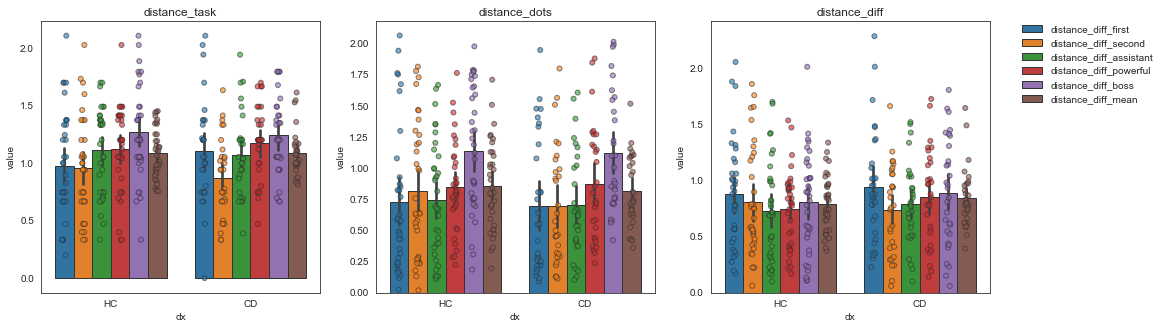

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(17,5))
for d, dist in enumerate(['distance_task','distance_dots','distance_diff']):

    melted = pd.melt(df, id_vars=['sub_id', 'dx'], value_vars=[dist + '_' + char for char in character_roles + ['mean']])
    sns.barplot(x='dx', y='value', hue='variable', data=melted, edgecolor='.2', ax=axs[d])
    sns.stripplot(x='dx', y='value', hue='variable', data=melted, 
                 dodge=True, edgecolor=".2", alpha=.6, linewidth=1, ax=axs[d])
    axs[d].set_title(dist)
    handles,labels = plt.gca().get_legend_handles_labels()
    if d == 2:
        axs[d].legend(title='', loc='upper right', handles=handles[6:],
                   frameon=False, bbox_to_anchor=(1.6, 1), borderaxespad=0)
    else:
        axs[d].get_legend().remove()
plt.show()

### ANOVAs & T-tests

In [72]:
long = pd.melt(dist_df, id_vars=['sub_id', 'dx', 'sex', 'race___white', 'ctq_total_score_2'], 
               value_vars=['distance_task.' + char for char in character_roles])
model = ols("value ~ C(sex, Sum) + C(race___white, Sum) + C(dx, Sum) + ctq_total_score_2", data=long).fit()
aov_table = sm.stats.anova_lm(model, typ=3)
display(aov_table)

,sum_sq,df,F,PR(>F)
Intercept,47.794178,1.0,290.963140,2.123564e-47
"C(sex, Sum)",0.102095,1.0,0.621535,4.310351e-01
"C(race___white, Sum)",0.318319,1.0,1.937872,1.648233e-01
"C(dx, Sum)",0.034970,1.0,0.212894,6.448078e-01
ctq_total_score_2,0.355263,1.0,2.162782,1.423272e-01
Residual,55.027760,335.0,NaN,NaN


# Correlations w/ drug use

# Correlations w/ functioning

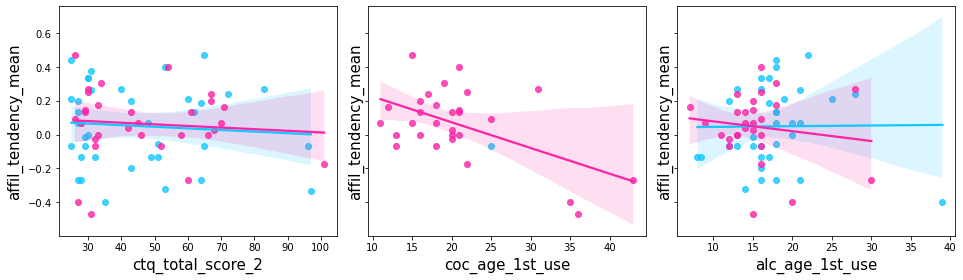

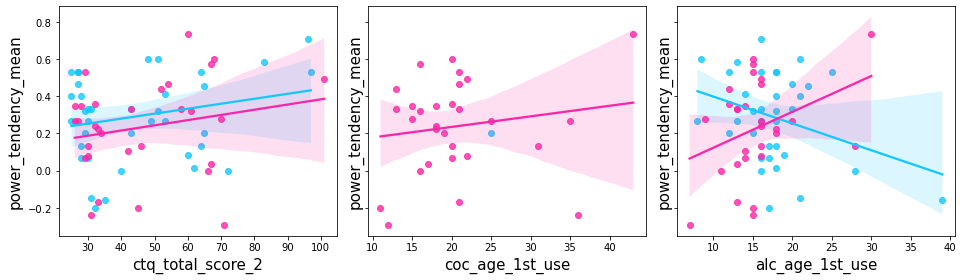

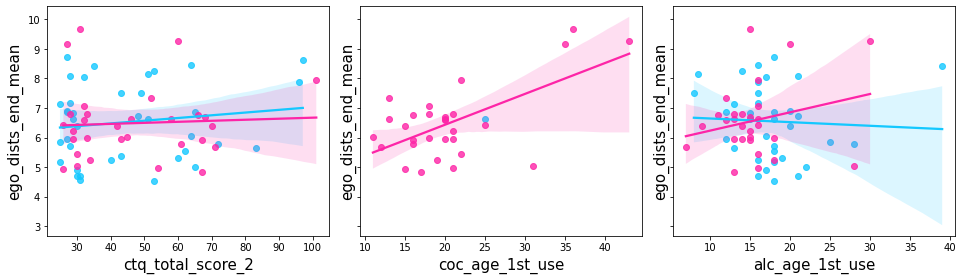

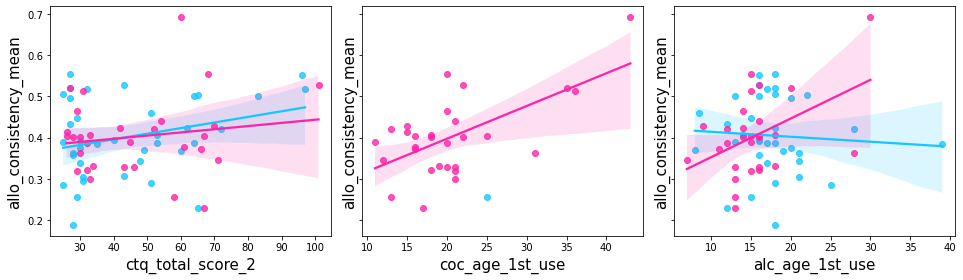

In [5]:
task_preds_ = ['affil_tendency_mean', 'power_tendency_mean',
               'ego_dists_end_mean','allo_consistency_mean']
lsas = ['lsas_social_interaction_fear_subscale', 'lsas_performance_fear_subscale',
        'lsas_social_interaction_avoidance_subscale', 'lsas_performance_avoidance_subscale',
        'lsas_total_score']
sni = ['sni_num_ppl', 'sni_network_div']
isel = ['isel_scr_appraisal_subscale', 'isel_scr_tangible_subscale', 'isel_scr_selfesteem_subscale']
ctq = ['ctq_physical_abuse_score','ctq_emotional_abuse_score',
       'ctq_sexual_abuse_score', 'ctq_emotional_neglect_score','ctq_physical_neglect_scale',
       'ctq_minimization_score', 'ctq_total_score_2']

questionnaires = ['ctq_total_score_2', 'coc_age_1st_use', 'alc_age_1st_use']
for var in task_preds_:
    if 'angles' not in var:
        hc = df[df['dx'] == 'HC']
        cd = df[df['dx'] == 'CD'] 
        fig, axs = plt.subplots(1, len(questionnaires), figsize=(len(questionnaires)*4.5, 4), sharey=True)
        for q, ques in enumerate(questionnaires):
            sns.regplot(x=ques, y=var, data=hc, color=group_colors[0], ax=axs[q])
            sns.regplot(x=ques, y=var, data=cd, color=group_colors[1], ax=axs[q])
            axs[q].set_xlabel(ques, fontsize=15)
            axs[q].set_ylabel(var, fontsize=15)
        plt.tight_layout()

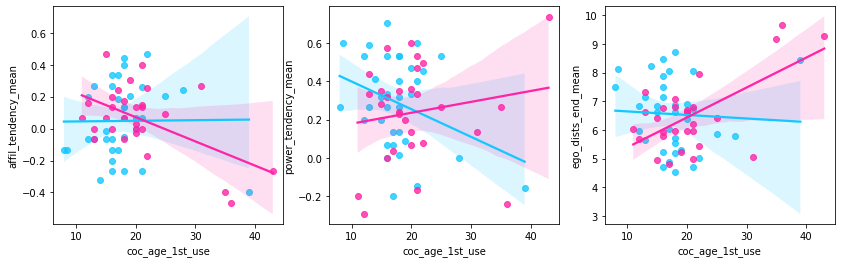

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

sns.regplot(x='alc_age_1st_use', y='affil_tendency_mean', data=hc, color=group_colors[0], ax=axs[0])
sns.regplot(x='coc_age_1st_use', y='affil_tendency_mean', data=cd, color=group_colors[1], ax=axs[0])

sns.regplot(x='alc_age_1st_use', y='power_tendency_mean', data=hc, color=group_colors[0], ax=axs[1])
sns.regplot(x='coc_age_1st_use', y='power_tendency_mean', data=cd, color=group_colors[1], ax=axs[1])

sns.regplot(x='alc_age_1st_use', y='ego_dists_end_mean', data=hc, color=group_colors[0], ax=axs[2])
sns.regplot(x='coc_age_1st_use', y='ego_dists_end_mean', data=cd, color=group_colors[1], ax=axs[2])

plt.show()

## Addiction severity

## Age of first coc use

In [108]:
task_preds_ = ['affil_tendency_mean', 'power_tendency_mean',
               'ego2d_angles_end_mean','ego_dists_end_mean',
               'allo_consistency_mean','allo2d_area','allo3d_volume',
               'rt_affil_mean','rt_power_mean']
dists = ['distance_dots_mean', 'distance_diff_mean']
cocs = ['coc_dur_years', 'coc_age_reg_use', 'coc_age_1st_use']
# mask = df[coc] > 0
# 'lsas_total_score', 'sni_num_ppl'

In [282]:
preds_ = ['allo_consistency_mean', 'affil_tendency_mean', 'ego_dists_end_mean', 'distance_diff_mean']
for pred in preds_:
    
    #     y = cd[pred]
    #     X = sm.add_constant(cd[['coc_age_1st_use', 'ctq_total_score_2'] + demo_controls])
    #     X['sex'] = (X['sex']=='female') * 1 # dummy-coded 
    #     model = sm.OLS(y, X, missing='drop')
    
    formula = pred + " ~ coc_age_reg_use + ctq_total_score_2 + memory_mean + wrat_standard_score + " + (' + ').join(demo_controls)
    model   = ols(formula=formula, data=cd)
    results = model.fit()
    display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              mid_L_HPC   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.9376
Date:                Wed, 27 Jul 2022   Prob (F-statistic):              0.499
Time:                        10:59:38   Log-Likelihood:                -5.8365
No. Observations:                  29   AIC:                             27.67
Df Residuals:                      21   BIC:                             38.61
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8459      0.860      0.983      0.337      -0.943       2.635
sex[T.male]             0.0964      0.194      0.498      0.624      -0.307       0.499
coc_age_reg_use        -0.0083      0.009     -0.911      0.372      -0.027       0.011
ctq_total_score_2      -0.0063      0.004     -1.782      0.089      -0.014       0.001
memory_mean            -0.0201      0.419     -0.048      0.962      -0.890       0.850
wrat_standard_score    -0.0076      0.008     -0.908      0.374      -0.025       0.010
age_years               0.0068      0.008      0.803      0.431      -0.011       0.024
race___white            0.0761      0.203      0.374      0.712      -0.347       0.499
==============================================================================
Omnibus:                        0.948   Durbin-Watson:                   2.749
Prob(Omnibus):                  0.623   Jarque-Bera (JB):                0.637
Skew:                           0.358   Prob(JB):                        0.727
Kurtosis:                       2.876   Cond. No.                     1.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     allo_consistency_mean   R-squared:                       0.431
Model:                               OLS   Adj. R-squared:                  0.241
Method:                    Least Squares   F-statistic:                     2.270
Date:                   Wed, 27 Jul 2022   Prob (F-statistic):             0.0690
Time:                           10:59:38   Log-Likelihood:                 36.042
No. Observations:                     29   AIC:                            -56.08
Df Residuals:                         21   BIC:                            -45.15
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0227      0.203      0.112      0.912      -0.399       0.445
sex[T.male]             0.0096      0.046      0.210      0.836      -0.085       0.105
coc_age_reg_use         0.0051      0.002      2.357      0.028       0.001       0.010
ctq_total_score_2       0.0009      0.001      1.130      0.271      -0.001       0.003
memory_mean             0.0536      0.099      0.543      0.593      -0.152       0.259
wrat_standard_score     0.0007      0.002      0.355      0.726      -0.003       0.005
age_years               0.0024      0.002      1.208      0.241      -0.002       0.007
race___white           -0.0416      0.048     -0.866      0.396      -0.141       0.058
==============================================================================
Omnibus:                        0.123   Durbin-Watson:                   1.450
Prob(Omnibus):                  0.941   Jarque-Bera (JB):                0.217
Skew:                          -0.135   Prob(JB):                        0.897
Kurtosis:                       2.674   Cond. No.                     1.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     affil_tendency_mean   R-squared:                       0.554
Model:                             OLS   Adj. R-squared:                  0.405
Method:                  Least Squares   F-statistic:                     3.721
Date:                 Wed, 27 Jul 2022   Prob (F-statistic):            0.00898
Time:                         10:59:38   Log-Likelihood:                 16.581
No. Observations:                   29   AIC:                            -17.16
Df Residuals:                       21   BIC:                            -6.223
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.1221      0.397      2.825      0.010       0.296       1.948
sex[T.male]             0.1024      0.089      1.145      0.265      -0.084       0.288
coc_age_reg_use        -0.0184      0.004     -4.367      0.000      -0.027      -0.010
ctq_total_score_2      -0.0022      0.002     -1.326      0.199      -0.006       0.001
memory_mean            -0.1156      0.193     -0.598      0.556      -0.517       0.286
wrat_standard_score     0.0008      0.004      0.207      0.838      -0.007       0.009
age_years              -0.0123      0.004     -3.145      0.005      -0.020      -0.004
race___white           -0.1346      0.094     -1.434      0.166      -0.330       0.061
==============================================================================
Omnibus:                        0.630   Durbin-Watson:                   2.173
Prob(Omnibus):                  0.730   Jarque-Bera (JB):                0.719
Skew:                          -0.224   Prob(JB):                        0.698
Kurtosis:                       2.372   Cond. No.                     1.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     ego_dists_end_mean   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     4.778
Date:                Wed, 27 Jul 2022   Prob (F-statistic):            0.00242
Time:                        10:59:38   Log-Likelihood:                -32.751
No. Observations:                  29   AIC:                             81.50
Df Residuals:                      21   BIC:                             92.44
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.5476      2.176     -0.252      0.804      -5.074       3.978
sex[T.male]            -0.6757      0.490     -1.378      0.183      -1.695       0.344
coc_age_reg_use         0.1121      0.023      4.859      0.000       0.064       0.160
ctq_total_score_2       0.0102      0.009      1.143      0.266      -0.008       0.029
memory_mean             0.7416      1.059      0.701      0.491      -1.460       2.943
wrat_standard_score     0.0028      0.021      0.132      0.896      -0.041       0.047
age_years               0.0748      0.021      3.498      0.002       0.030       0.119
race___white            0.5451      0.514      1.059      0.301      -0.525       1.615
==============================================================================
Omnibus:                        0.466   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.792   Jarque-Bera (JB):                0.599
Skew:                          -0.166   Prob(JB):                        0.741
Kurtosis:                       2.379   Cond. No.                     1.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     distance_diff_mean   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     3.180
Date:                Wed, 27 Jul 2022   Prob (F-statistic):             0.0186
Time:                        10:59:38   Log-Likelihood:                 7.9287
No. Observations:                  29   AIC:                            0.1426
Df Residuals:                      21   BIC:                             11.08
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1862      0.535      0.348      0.731      -0.927       1.299
sex[T.male]            -0.3149      0.121     -2.613      0.016      -0.566      -0.064
coc_age_reg_use         0.0187      0.006      3.288      0.004       0.007       0.030
ctq_total_score_2       0.0009      0.002      0.397      0.695      -0.004       0.005
memory_mean             0.3505      0.260      1.346      0.193      -0.191       0.892
wrat_standard_score    -0.0018      0.005     -0.350      0.730      -0.013       0.009
age_years               0.0100      0.005      1.893      0.072      -0.001       0.021
race___white           -0.1948      0.127     -1.540      0.139      -0.458       0.068
==============================================================================
Omnibus:                        2.975   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                2.061
Skew:                           0.651   Prob(JB):                        0.357
Kurtosis:                       3.091   Cond. No.                     1.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Age of first alc use - way to combine both samples...

In [285]:
# Age of alc first use as proxy for HCs
# hc = df[df['dx'] == 'HC']
formula = "ego_dists_end_mean ~ alc_age_1st_use + ctq_total_score_2 + memory_mean + wrat_standard_score + dx + " + (' + ').join(demo_controls)
model = ols(formula=formula, data=df)
results = model.fit()
display(results.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     ego_dists_end_mean   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     2.123
Date:                Wed, 27 Jul 2022   Prob (F-statistic):             0.0503
Time:                        11:00:57   Log-Likelihood:                -87.418
No. Observations:                  60   AIC:                             192.8
Df Residuals:                      51   BIC:                             211.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.4331      2.152      1.131      0.263      -1.887       6.753
dx[T.HC]                0.0901      0.315      0.286      0.776      -0.542       0.722
sex[T.male]            -0.1853      0.388     -0.478      0.635      -0.964       0.593
alc_age_1st_use         0.0409      0.030      1.350      0.183      -0.020       0.102
ctq_total_score_2       0.0032      0.008      0.401      0.690      -0.013       0.019
memory_mean             1.4345      0.892      1.608      0.114      -0.356       3.225
wrat_standard_score    -0.0004      0.020     -0.021      0.983      -0.040       0.039
age_years               0.0588      0.017      3.362      0.001       0.024       0.094
race___white           -0.2723      0.340     -0.801      0.427      -0.954       0.410
==============================================================================
Omnibus:                        3.771   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.152   Jarque-Bera (JB):                2.250
Skew:                           0.246   Prob(JB):                        0.325
Kurtosis:                       2.188   Cond. No.                     1.87e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Correlations w/ childhood trauma

## Childhood trauma (CTQ)

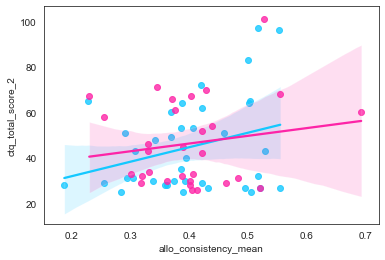

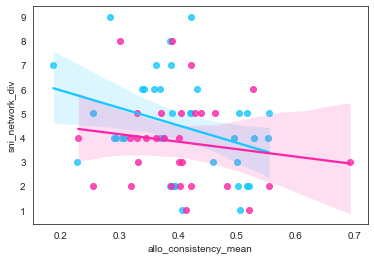

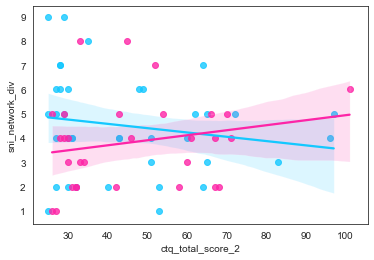

In [123]:
sns.regplot(y='ctq_total_score_2', x='allo_consistency_mean', data=hc, color=pal[0])
sns.regplot(y='ctq_total_score_2', x='allo_consistency_mean', data=cd, color=pal[1])
plt.show()

sns.regplot(y='sni_network_div', x='allo_consistency_mean', data=hc, color=pal[0])
sns.regplot(y='sni_network_div', x='allo_consistency_mean', data=cd, color=pal[1])
plt.show()

sns.regplot(y='sni_network_div', x='ctq_total_score_2', data=hc, color=pal[0])
sns.regplot(y='sni_network_div', x='ctq_total_score_2', data=cd, color=pal[1])
plt.show()

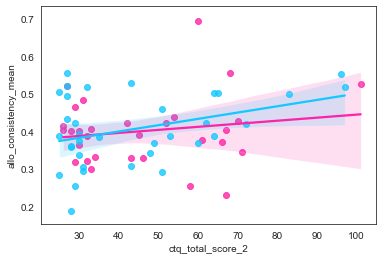

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      ctq_total_score_2   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     1.716
Date:                Thu, 28 Jul 2022   Prob (F-statistic):              0.107
Time:                        16:52:14   Log-Likelihood:                -277.51
No. Observations:                  65   AIC:                             575.0
Df Residuals:                      55   BIC:                             596.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 19.9060     33.116      0.601      0.550     -46.460      86.272
dx[T.HC]                  -6.8001      5.148     -1.321      0.192     -17.118       3.517
sex[T.male]               -8.6904      6.630     -1.311      0.195     -21.977       4.596
allo_consistency_mean    218.9787     61.446      3.564      0.001      95.837     342.120
power_consistency_mean   -71.6749     31.493     -2.276      0.027    -134.788      -8.561
affil_consistency_mean   -68.1498     29.339     -2.323      0.024    -126.947      -9.353
memory_mean              -10.9598     15.668     -0.699      0.487     -42.360      20.440
wrat_standard_score       -0.0499      0.313     -0.159      0.874      -0.677       0.577
age_years                 -0.0112      0.285     -0.039      0.969      -0.582       0.559
race___white               6.6091      5.539      1.193      0.238      -4.491      17.709
==============================================================================
Omnibus:                        4.953   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                4.647
Skew:                           0.655   Prob(JB):                       0.0979
Kurtosis:                       2.971   Cond. No.                     3.54e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [303]:
cd = df[df['dx'] == 'CD']
hc = df[df['dx'] == 'HC']
x = 'ctq_total_score_2'
y = 'allo_consistency_mean'
sns.regplot(y=y, x=x, data=cd, color=pal[1])
sns.regplot(y=y, x=x, data=hc, color=pal[0])
plt.show()
formula = "ctq_total_score_2 ~ allo_consistency_mean + power_consistency_mean + affil_consistency_mean + memory_mean + wrat_standard_score + dx + " + (' + ').join(demo_controls)
model = ols(formula=formula, data=df)
results = model.fit()
display(results.summary())

### Diff subscores

In [281]:
preds_ = ['allo_consistency_mean']  # 'post_L_HPC', 'sni_num_ppl'
for pred in preds_:
    
    for ctq in [c for c in df.columns if 'ctq' in c]:
    
    #     y = df[pred]
    #     X = sm.add_constant(df[['ctq_total_score_2', 'memory_mean', 'dx'] + demo_controls])
    #     X['sex'] = (X['sex']=='female') * 1
    #     X['dx'] = (X['dx']=='CD') * 1
    #     model = sm.OLS(y, X, missing='drop')

        formula = pred + " ~ " + ctq + " + memory_mean + wrat_standard_score + dx + " + (' + ').join(demo_controls)
        model = ols(formula=formula, data=df)
        results = model.fit()
        display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     allo_consistency_mean   R-squared:                       0.212
Model:                               OLS   Adj. R-squared:                  0.115
Method:                    Least Squares   F-statistic:                     2.184
Date:                   Wed, 27 Jul 2022   Prob (F-statistic):             0.0491
Time:                           10:58:28   Log-Likelihood:                 70.839
No. Observations:                     65   AIC:                            -125.7
Df Residuals:                         57   BIC:                            -108.3
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.2063      0.152      1.354      0.181      -0.099       0.511
dx[T.HC]                     0.0240      0.023      1.047      0.300      -0.022       0.070
sex[T.male]                  0.0095      0.029      0.325      0.746      -0.049       0.068
ctq_physical_abuse_score     0.0042      0.002      2.044      0.046    8.47e-05       0.008
memory_mean                  0.0996      0.066      1.506      0.138      -0.033       0.232
wrat_standard_score          0.0005      0.001      0.362      0.718      -0.002       0.003
age_years                    0.0011      0.001      0.864      0.391      -0.001       0.004
race___white                -0.0539      0.024     -2.201      0.032      -0.103      -0.005
==============================================================================
Omnibus:                        2.896   Durbin-Watson:                   1.381
Prob(Omnibus):                  0.235   Jarque-Bera (JB):                2.088
Skew:                           0.399   Prob(JB):                        0.352
Kurtosis:                       3.367   Cond. No.                     1.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     allo_consistency_mean   R-squared:                       0.228
Model:                               OLS   Adj. R-squared:                  0.133
Method:                    Least Squares   F-statistic:                     2.404
Date:                   Wed, 27 Jul 2022   Prob (F-statistic):             0.0315
Time:                           10:58:28   Log-Likelihood:                 71.524
No. Observations:                     65   AIC:                            -127.0
Df Residuals:                         57   BIC:                            -109.7
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2176      0.149      1.463      0.149      -0.080       0.515
dx[T.HC]                      0.0185      0.023      0.814      0.419      -0.027       0.064
sex[T.male]                   0.0203      0.029      0.709      0.481      -0.037       0.078
ctq_emotional_abuse_score     0.0043      0.002      2.341      0.023       0.001       0.008
memory_mean                   0.0956      0.066      1.458      0.150      -0.036       0.227
wrat_standard_score           0.0003      0.001      0.209      0.835      -0.003       0.003
age_years                     0.0013      0.001      1.006      0.319      -0.001       0.004
race___white                 -0.0620      0.024     -2.544      0.014      -0.111      -0.013
==============================================================================
Omnibus:                        2.239   Durbin-Watson:                   1.333
Prob(Omnibus):                  0.327   Jarque-Bera (JB):                1.728
Skew:                           0.396   Prob(JB):                        0.422
Kurtosis:                       3.102   Cond. No.                     1.64e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     allo_consistency_mean   R-squared:                       0.184
Model:                               OLS   Adj. R-squared:                  0.084
Method:                    Least Squares   F-statistic:                     1.836
Date:                   Wed, 27 Jul 2022   Prob (F-statistic):             0.0978
Time:                           10:58:28   Log-Likelihood:                 69.726
No. Observations:                     65   AIC:                            -123.5
Df Residuals:                         57   BIC:                            -106.1
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.2798      0.150      1.864      0.068      -0.021       0.581
dx[T.HC]                   0.0284      0.024      1.201      0.235      -0.019       0.076
sex[T.male]                0.0292      0.030      0.969      0.336      -0.031       0.090
ctq_sexual_abuse_score     0.0030      0.002      1.454      0.151      -0.001       0.007
memory_mean                0.1109      0.067      1.656      0.103      -0.023       0.245
wrat_standard_score       -0.0002      0.001     -0.127      0.900      -0.003       0.003
age_years                  0.0010      0.001      0.787      0.435      -0.002       0.004
race___white              -0.0590      0.025     -2.358      0.022      -0.109      -0.009
==============================================================================
Omnibus:                        0.280   Durbin-Watson:                   1.387
Prob(Omnibus):                  0.869   Jarque-Bera (JB):                0.199
Skew:                           0.131   Prob(JB):                        0.906
Kurtosis:                       2.929   Cond. No.                     1.60e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     allo_consistency_mean   R-squared:                       0.255
Model:                               OLS   Adj. R-squared:                  0.163
Method:                    Least Squares   F-statistic:                     2.783
Date:                   Wed, 27 Jul 2022   Prob (F-statistic):             0.0146
Time:                           10:58:28   Log-Likelihood:                 72.670
No. Observations:                     65   AIC:                            -129.3
Df Residuals:                         57   BIC:                            -111.9
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.2178      0.145      1.498      0.140      -0.073       0.509
dx[T.HC]                        0.0270      0.022      1.208      0.232      -0.018       0.072
sex[T.male]                     0.0224      0.028      0.795      0.430      -0.034       0.079
ctq_emotional_neglect_score     0.0058      0.002      2.779      0.007       0.002       0.010
memory_mean                     0.1230      0.064      1.918      0.060      -0.005       0.251
wrat_standard_score         -1.452e-05      0.001     -0.010      0.992      -0.003       0.003
age_years                       0.0011      0.001      0.853      0.397      -0.001       0.004
race___white                   -0.0541      0.024     -2.276      0.027      -0.102      -0.007
==============================================================================
Omnibus:                        2.532   Durbin-Watson:                   1.490
Prob(Omnibus):                  0.282   Jarque-Bera (JB):                2.297
Skew:                           0.367   Prob(JB):                        0.317
Kurtosis:                       2.444   Cond. No.                     1.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     allo_consistency_mean   R-squared:                       0.211
Model:                               OLS   Adj. R-squared:                  0.114
Method:                    Least Squares   F-statistic:                     2.172
Date:                   Wed, 27 Jul 2022   Prob (F-statistic):             0.0503
Time:                           10:58:28   Log-Likelihood:                 70.800
No. Observations:                     65   AIC:                            -125.6
Df Residuals:                         57   BIC:                            -108.2
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.2294      0.150      1.529      0.132      -0.071       0.530
dx[T.HC]                       0.0320      0.023      1.366      0.177      -0.015       0.079
sex[T.male]                    0.0328      0.030      1.106      0.273      -0.027       0.092
ctq_physical_neglect_scale     0.0095      0.005      2.025      0.048       0.000       0.019
memory_mean                    0.1082      0.066      1.641      0.106      -0.024       0.240
wrat_standard_score           -0.0002      0.001     -0.158      0.875      -0.003       0.003
age_years                      0.0012      0.001      0.911      0.366      -0.001       0.004
race___white                  -0.0571      0.024     -2.332      0.023      -0.106      -0.008
==============================================================================
Omnibus:                        3.033   Durbin-Watson:                   1.442
Prob(Omnibus):                  0.219   Jarque-Bera (JB):                2.239
Skew:                           0.423   Prob(JB):                        0.326
Kurtosis:                       3.335   Cond. No.                     1.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     allo_consistency_mean   R-squared:                       0.173
Model:                               OLS   Adj. R-squared:                  0.072
Method:                    Least Squares   F-statistic:                     1.708
Date:                   Wed, 27 Jul 2022   Prob (F-statistic):              0.125
Time:                           10:58:28   Log-Likelihood:                 69.305
No. Observations:                     65   AIC:                            -122.6
Df Residuals:                         57   BIC:                            -105.2
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.3072      0.152      2.015      0.049       0.002       0.613
dx[T.HC]                   0.0217      0.024      0.923      0.360      -0.025       0.069
sex[T.male]                0.0219      0.030      0.737      0.464      -0.038       0.081
ctq_minimization_score    -0.0128      0.011     -1.164      0.249      -0.035       0.009
memory_mean                0.1132      0.067      1.679      0.099      -0.022       0.248
wrat_standard_score        0.0001      0.001      0.084      0.933      -0.003       0.003
age_years                  0.0010      0.001      0.752      0.455      -0.002       0.004
race___white              -0.0596      0.025     -2.353      0.022      -0.110      -0.009
==============================================================================
Omnibus:                        1.134   Durbin-Watson:                   1.510
Prob(Omnibus):                  0.567   Jarque-Bera (JB):                0.782
Skew:                           0.267   Prob(JB):                        0.676
Kurtosis:                       3.057   Cond. No.                     1.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     allo_consistency_mean   R-squared:                       0.246
Model:                               OLS   Adj. R-squared:                  0.153
Method:                    Least Squares   F-statistic:                     2.651
Date:                   Wed, 27 Jul 2022   Prob (F-statistic):             0.0191
Time:                           10:58:28   Log-Likelihood:                 72.276
No. Observations:                     65   AIC:                            -128.6
Df Residuals:                         57   BIC:                            -111.2
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.2095      0.147      1.425      0.160      -0.085       0.504
dx[T.HC]                0.0270      0.022      1.198      0.236      -0.018       0.072
sex[T.male]             0.0234      0.028      0.827      0.412      -0.033       0.080
ctq_total_score_2       0.0014      0.001      2.635      0.011       0.000       0.003
memory_mean             0.1039      0.064      1.611      0.113      -0.025       0.233
wrat_standard_score     0.0001      0.001      0.099      0.921      -0.003       0.003
age_years               0.0011      0.001      0.880      0.382      -0.001       0.004
race___white           -0.0588      0.024     -2.453      0.017      -0.107      -0.011
==============================================================================
Omnibus:                        1.635   Durbin-Watson:                   1.343
Prob(Omnibus):                  0.442   Jarque-Bera (JB):                1.319
Skew:                           0.349   Prob(JB):                        0.517
Kurtosis:                       2.985   Cond. No.                     1.75e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### All subscores in same model

In [271]:
formula = "allo_consistency_mean ~ memory_mean + wrat_standard_score + dx + " + (' + ').join(demo_controls) + " + " + (' + ').join([c for c in df.columns if 'ctq' in c])
model = ols(formula=formula, data=df)
results = model.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     allo_consistency_mean   R-squared:                       0.267
Model:                               OLS   Adj. R-squared:                  0.098
Method:                    Least Squares   F-statistic:                     1.579
Date:                   Wed, 27 Jul 2022   Prob (F-statistic):              0.127
Time:                           01:46:45   Log-Likelihood:                 73.215
No. Observations:                     65   AIC:                            -120.4
Df Residuals:                         52   BIC:                            -92.16
Df Model:                             12                                         
Covariance Type:               nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.1972      0.160      1.231      0.224      -0.124       0.519
dx[T.HC]                        0.0227      0.025      0.900      0.372      -0.028       0.073
sex[T.male]                     0.0225      0.033      0.689      0.494      -0.043       0.088
memory_mean                     0.1120      0.068      1.649      0.105      -0.024       0.248
wrat_standard_score          9.612e-05      0.002      0.063      0.950      -0.003       0.003
age_years                       0.0012      0.001      0.918      0.363      -0.001       0.004
race___white                   -0.0579      0.026     -2.262      0.028      -0.109      -0.007
ctq_physical_abuse_score       -0.0018      0.004     -0.478      0.635      -0.009       0.006
ctq_emotional_abuse_score       0.0018      0.004      0.438      0.663      -0.006       0.010
ctq_sexual_abuse_score         -0.0014      0.003     -0.518      0.607      -0.007       0.004
ctq_emotional_neglect_score     0.0036      0.003      1.073      0.288      -0.003       0.010
ctq_physical_neglect_scale     -0.0011      0.006     -0.173      0.863      -0.014       0.011
ctq_minimization_score          0.0021      0.013      0.160      0.873      -0.024       0.028
ctq_total_score_2               0.0011      0.001      1.231      0.224      -0.001       0.003
==============================================================================
Omnibus:                        2.456   Durbin-Watson:                   1.417
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                2.392
Skew:                           0.416   Prob(JB):                        0.302
Kurtosis:                       2.565   Cond. No.                     3.67e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.7e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Correlations w/ social functioning

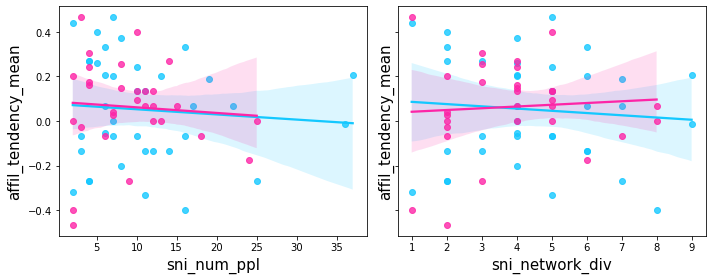

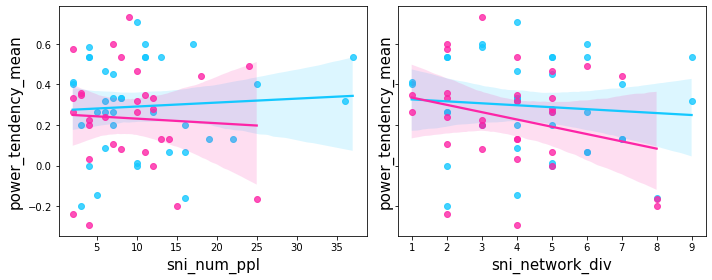

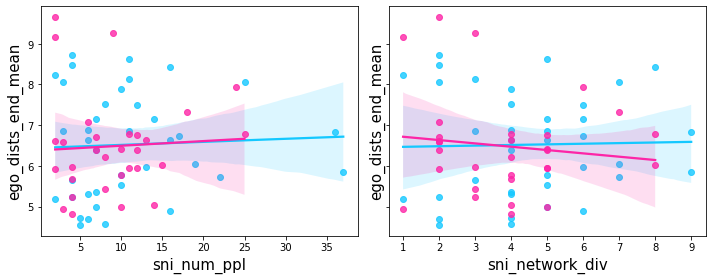

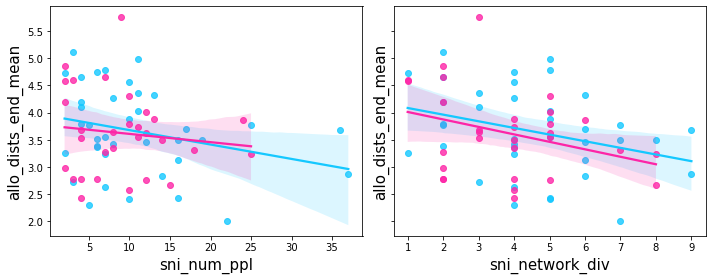

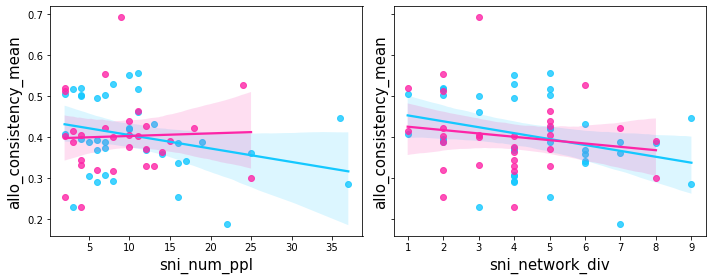

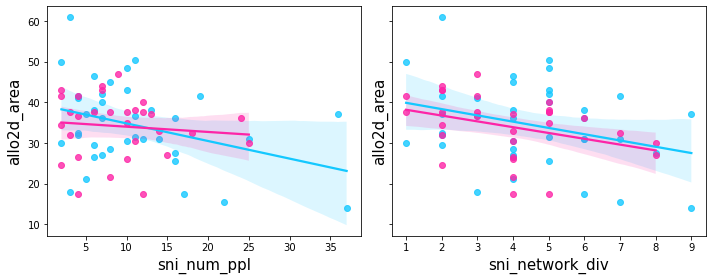

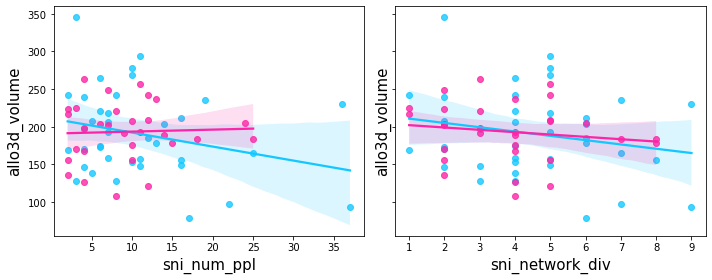

In [22]:
lsas = ['lsas_social_interaction_fear_subscale', 'lsas_performance_fear_subscale',
        'lsas_social_interaction_avoidance_subscale', 'lsas_performance_avoidance_subscale',
        'lsas_total_score']
sni = ['sni_num_ppl', 'sni_network_div']
isel = ['isel_scr_appraisal_subscale', 'isel_scr_tangible_subscale', 'isel_scr_selfesteem_subscale']
ctq = ['ctq_physical_abuse_score','ctq_emotional_abuse_score',
       'ctq_sexual_abuse_score', 'ctq_emotional_neglect_score','ctq_physical_neglect_scale',
       'ctq_minimization_score', 'ctq_total_score_2']

questionnaires = sni
for var in task_preds:
    if 'angles' not in var:
        hc = df[df['dx'] == 'HC']
        cd = df[df['dx'] == 'CD'] 
        fig, axs = plt.subplots(1, len(questionnaires), figsize=(10, 4), sharey=True)
        for q, ques in enumerate(questionnaires):
            sns.regplot(x=ques, y=var, data=hc, color=group_colors[0], ax=axs[q])
            sns.regplot(x=ques, y=var, data=cd, color=group_colors[1], ax=axs[q])
            axs[q].set_xlabel(ques, fontsize=15)
            axs[q].set_ylabel(var, fontsize=15)
        plt.tight_layout()

## social anxiety

MannwhitneyuResult(statistic=500.0, pvalue=0.8065593201032879)

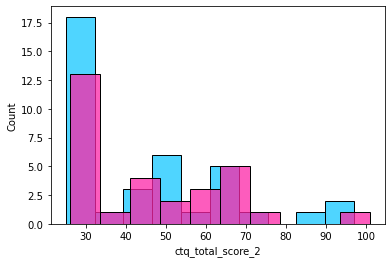

In [24]:
lsas = 'ctq_total_score_2'
sns.histplot(hc[lsas], color=group_colors[0], bins=10)
sns.histplot(cd[lsas], color=group_colors[1], bins=10)
scipy.stats.mannwhitneyu(hc[lsas], cd[lsas], alternative='greater', use_continuity=False, axis=0, method='auto')

### allo consistency & childhood trauma

In [82]:
[c for c in df.columns if ('sni' in c)]

['sni_marital_status',
 'sni_numbr_children',
 'sni_numbr_children_contact',
 'sni_parents_living',
 'sni_parents_contact_biweekly',
 'sni_inlaws',
 'sni_in_laws_talk_biweekly',
 'sni_other_relatives_close_to',
 'sni_relatives_talk_to_biweekly',
 'sni_num_close_friends',
 'sni_friends_contact_biweekly',
 'sni_religious_affiliation',
 'sni_religious_affiliation_contact_biweekly',
 'sni_attend_classes_regularly',
 'sni_students_teachers_biweekly_contact',
 'sni_employment_status',
 'sni_ppl_supervise',
 'sni_coworkers_biweekly_contact',
 'sni_neighboors_biweekly_contact',
 'sni_reg_volunteer_work',
 'sni_volunteers_biweekly_contact',
 'sni_other_volunteer_grp_member_biweekly_contact',
 'sni_volunteer_grp_details',
 'sni_total_nmbr_other_volunteers_biweekly_contact',
 'sni_num_ppl',
 'sni_network_div']

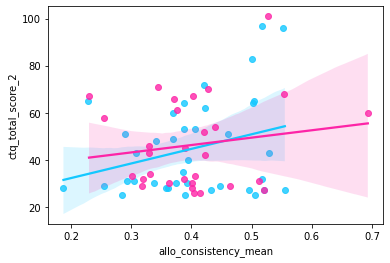

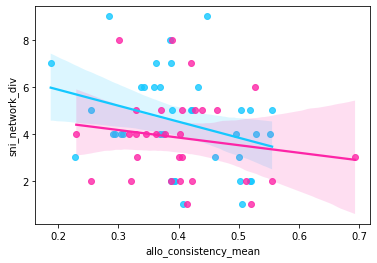

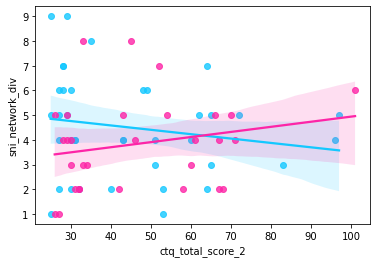

In [25]:
sns.regplot(y='ctq_total_score_2', x='allo_consistency_mean', data=hc, color=group_colors[0])
sns.regplot(y='ctq_total_score_2', x='allo_consistency_mean', data=cd, color=group_colors[1])
plt.show()

sns.regplot(y='sni_network_div', x='allo_consistency_mean', data=hc, color=group_colors[0])
sns.regplot(y='sni_network_div', x='allo_consistency_mean', data=cd, color=group_colors[1])
plt.show()

sns.regplot(y='sni_network_div', x='ctq_total_score_2', data=hc, color=group_colors[0])
sns.regplot(y='sni_network_div', x='ctq_total_score_2', data=cd, color=group_colors[1])
plt.show()

In [26]:
X = sm.add_constant(df[['ctq_total_score_2', 'sni_network_div', 'dx'] + demo_controls])
X['sex'] = (X['sex']=='female') * 1
X['dx']  = (X['dx']=='HC') * 1
y = df['allo_consistency_mean']

model = sm.OLS(y, X, missing='drop')
results = model.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     allo_consistency_mean   R-squared:                       0.267
Model:                               OLS   Adj. R-squared:                  0.195
Method:                    Least Squares   F-statistic:                     3.703
Date:                   Mon, 12 Sep 2022   Prob (F-statistic):            0.00333
Time:                           10:02:26   Log-Likelihood:                 75.858
No. Observations:                     68   AIC:                            -137.7
Df Residuals:                         61   BIC:                            -122.2
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3876      0.069      5.629      0.000       0.250       0.525
ctq_total_score_2     0.0013      0.001      2.446      0.017       0.000       0.002
sni_network_div      -0.0134      0.005     -2.520      0.014      -0.024      -0.003
dx                    0.0282      0.022      1.287      0.203      -0.016       0.072
sex                  -0.0259      0.024     -1.070      0.289      -0.074       0.022
age_years             0.0006      0.001      0.504      0.616      -0.002       0.003
race___white         -0.0654      0.023     -2.900      0.005      -0.111      -0.020
==============================================================================
Omnibus:                        1.093   Durbin-Watson:                   1.367
Prob(Omnibus):                  0.579   Jarque-Bera (JB):                0.875
Skew:                           0.277   Prob(JB):                        0.646
Kurtosis:                       2.960   Cond. No.                         461.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""